Successfully fetched 16190 records from API.
Loading data from CSV file: C:/Users/THENMOZHI/Downloads/archive/database.csv
Successfully loaded 23412 records from CSV.

Combined dataset shape: (39602, 7)
Soil map shapefile loaded successfully.
Performing spatial join to match earthquakes with soil types...
Soil data successfully merged with earthquake data.
magnitude_class
Strong      17250
Light       10602
Moderate     9865
Major        1882
Name: count, dtype: int64


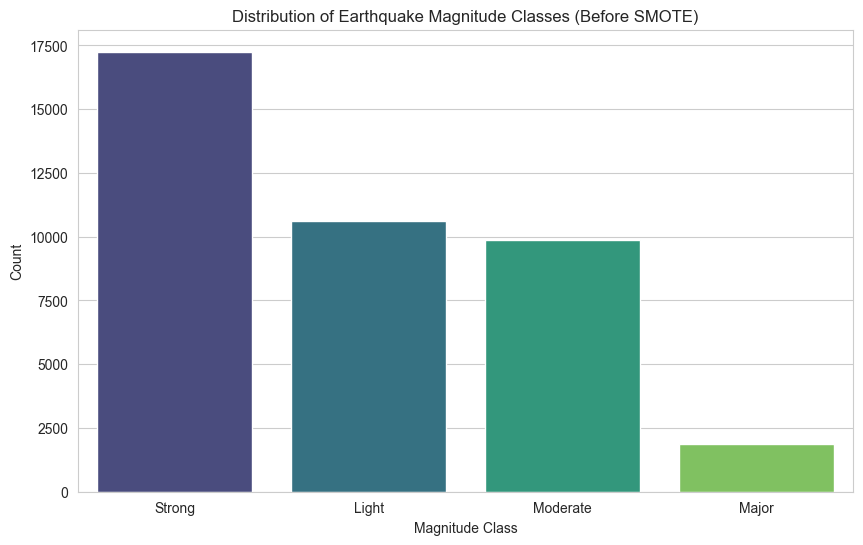

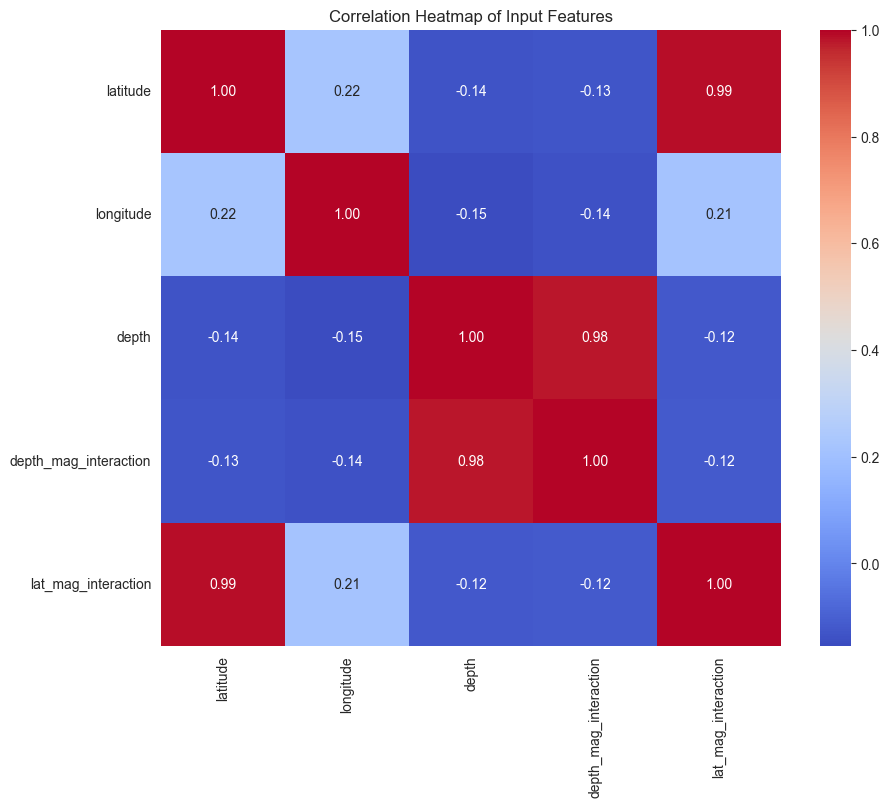

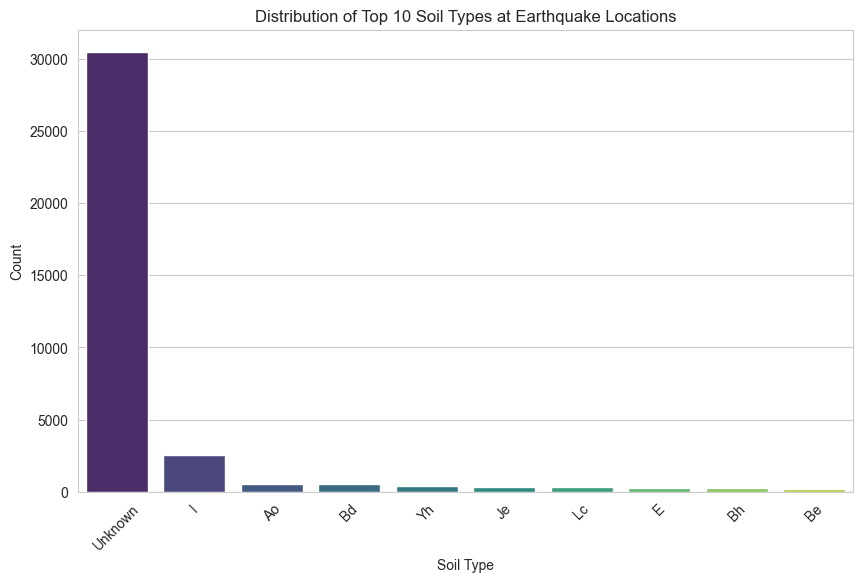

magnitude_class_encoded
3    12937
0     7951
2     7399
1     1412
Name: count, dtype: int64
magnitude_class_encoded
0    12937
1    12937
3    12937
2    12937
Name: count, dtype: int64


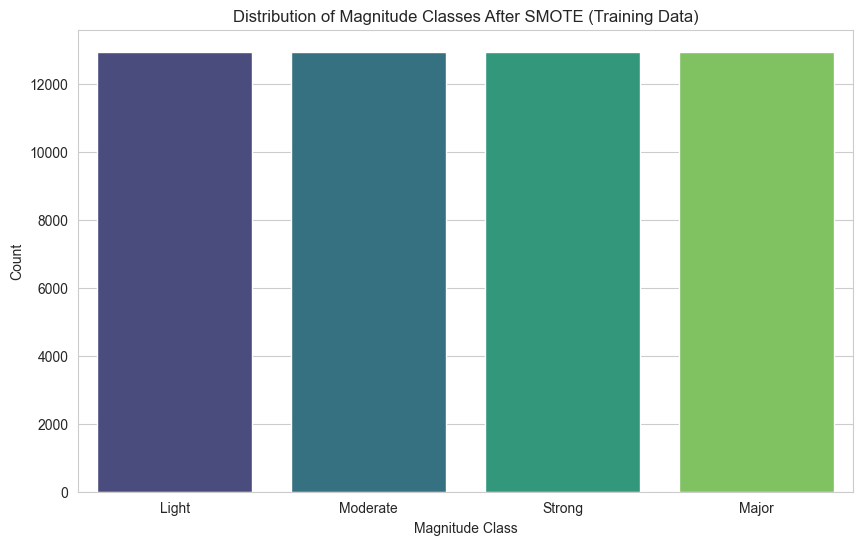


--- Evaluating Logistic Regression ---
Baseline Accuracy (without tuning): 0.7883
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters: {'C': 10, 'solver': 'saga'}
Tuned Accuracy (with GridSearchCV): 0.8995

Classification Report for Tuned Logistic Regression:
              precision    recall  f1-score   support

       Light       0.88      0.97      0.93      2651
       Major       0.67      0.98      0.80       470
    Moderate       0.84      0.85      0.85      2466
      Strong       0.99      0.87      0.93      4313

    accuracy                           0.90      9900
   macro avg       0.85      0.92      0.87      9900
weighted avg       0.91      0.90      0.90      9900



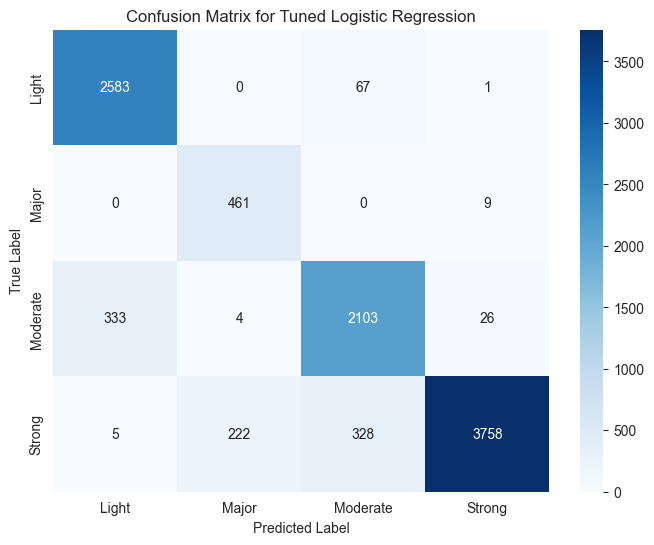


--- Evaluating Random Forest ---
Baseline Accuracy (without tuning): 0.8771
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Tuned Accuracy (with GridSearchCV): 0.8805

Classification Report for Tuned Random Forest:
              precision    recall  f1-score   support

       Light       0.93      0.95      0.94      2651
       Major       0.76      0.75      0.76       470
    Moderate       0.84      0.77      0.80      2466
      Strong       0.88      0.92      0.90      4313

    accuracy                           0.88      9900
   macro avg       0.85      0.85      0.85      9900
weighted avg       0.88      0.88      0.88      9900



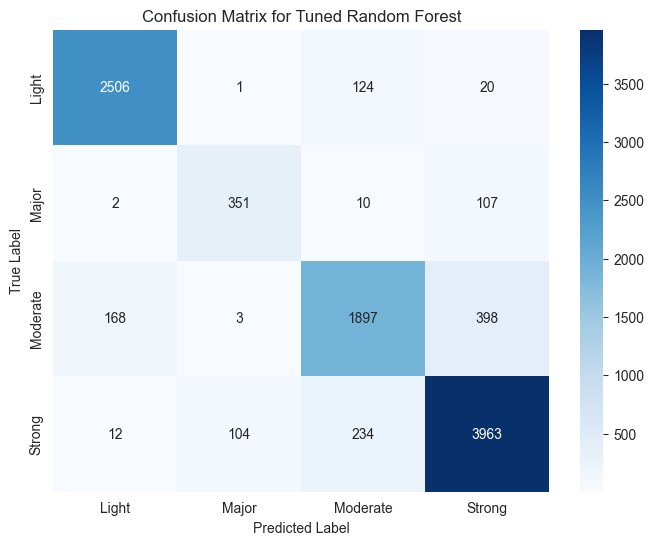

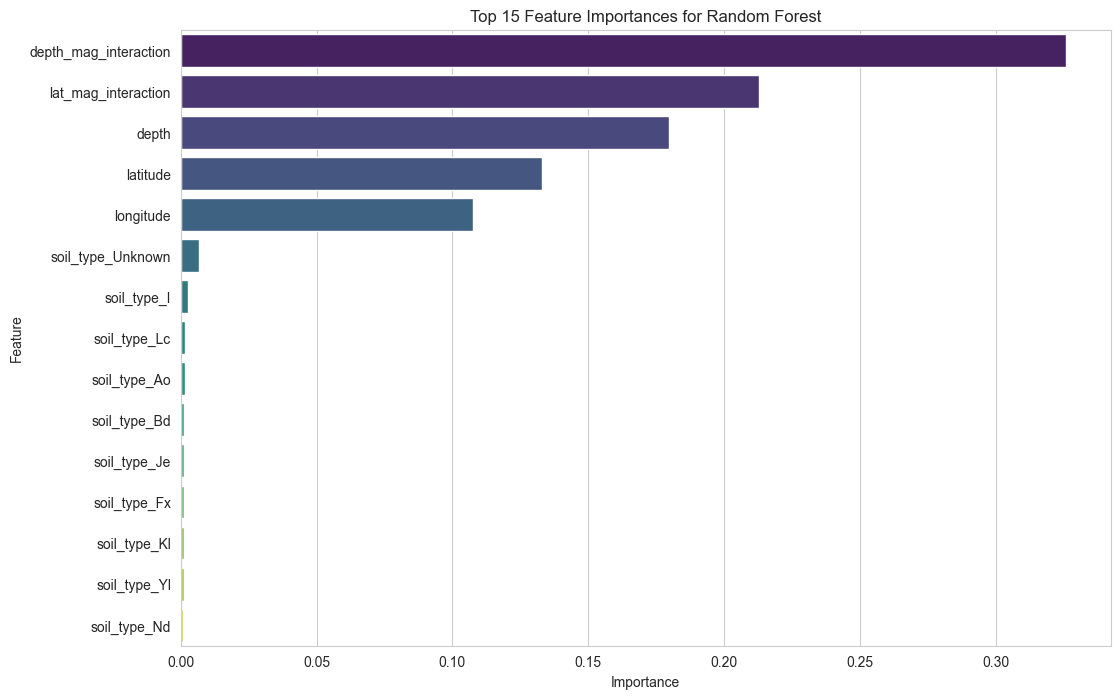


--- Evaluating XGBoost ---
Baseline Accuracy (without tuning): 0.9520
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}
Tuned Accuracy (with GridSearchCV): 0.9598

Classification Report for Tuned XGBoost:
              precision    recall  f1-score   support

       Light       0.98      0.99      0.98      2651
       Major       0.91      0.97      0.94       470
    Moderate       0.93      0.93      0.93      2466
      Strong       0.97      0.96      0.96      4313

    accuracy                           0.96      9900
   macro avg       0.95      0.96      0.95      9900
weighted avg       0.96      0.96      0.96      9900



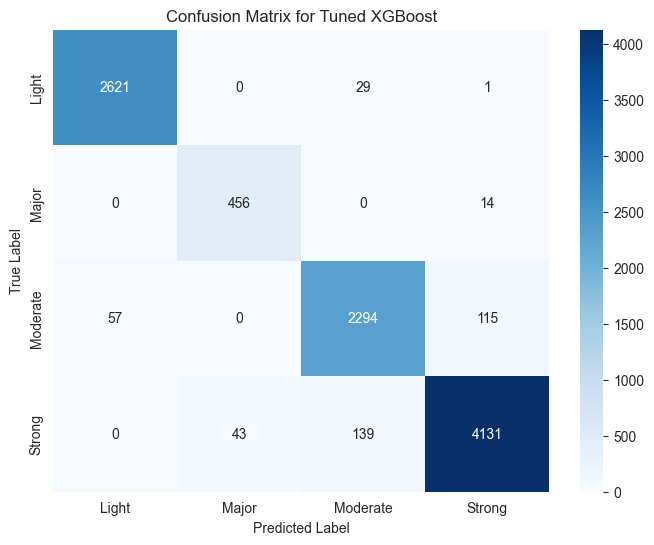

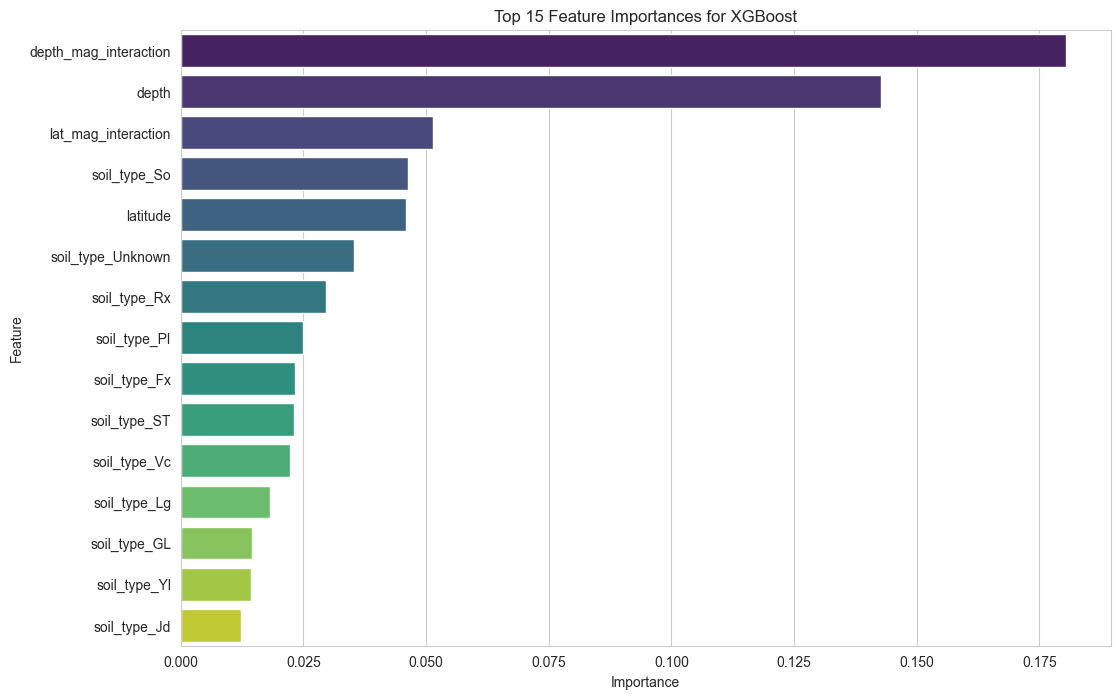


--- Summary ---
Best performing model is XGBoost with a tuned accuracy of 0.9598

Hyperparameters of the Best Model (XGBoost):
{'objective': 'multi:softprob', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'mlogloss', 'feature_types': None, 'feature_weights': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.2, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 7, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 200, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': Non

In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import warnings
import joblib

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)

def fetch_api_data():
    url = "https://earthquake.usgs.gov/fdsnws/event/1/query"
    params = {
        "format": "geojson",
        "starttime": "2023-01-01",
        "endtime": "2023-12-31",
        "minmagnitude": 4.0
    }
    try:
        response = requests.get(url, params=params, timeout=30)
        response.raise_for_status()
        data = response.json()
        
        records = []
        for feat in data['features']:
            props = feat['properties']
            geom = feat['geometry']
            records.append({
                "time": pd.to_datetime(props['time'], unit='ms'),
                "latitude": geom['coordinates'][1],
                "longitude": geom['coordinates'][0],
                "depth": geom['coordinates'][2],
                "magnitude": props['mag'],
                "type": props['type'],
                "status": props['status']
            })
        df = pd.DataFrame(records)
        print(f"Successfully fetched {len(df)} records from API.")
        return df
    except requests.exceptions.RequestException as e:
        print(f"Error fetching API data: {e}")
        return pd.DataFrame()

def load_csv_data(file_path):
    print(f"Loading data from CSV file: {file_path}")
    try:
        df = pd.read_csv(file_path)
        df = df[['Date', 'Time', 'Latitude', 'Longitude', 'Depth', 'Magnitude', 'Type', 'Status']]
        df.columns = [col.lower() for col in df.columns]
        df['time'] = pd.to_datetime(df['date'] + ' ' + df['time'], errors='coerce')
        df = df.drop(columns=['date'])
        print(f"Successfully loaded {len(df)} records from CSV.")
        return df
    except FileNotFoundError:
        print(f"Error: The file was not found at {file_path}")
        return pd.DataFrame()

CSV_FILE_PATH = "C:/Users/THENMOZHI/Downloads/archive/database.csv"
SHAPEFILE_PATH = "C:/Users/THENMOZHI/Downloads/DSMW/DSMW.shp" 

df_api = fetch_api_data()
df_csv = load_csv_data(CSV_FILE_PATH)

df = pd.concat([df_api, df_csv], ignore_index=True)
print(f"\nCombined dataset shape: {df.shape}")

df = df.dropna(subset=['time'])

for col in ['latitude', 'longitude', 'depth', 'magnitude']:
    df[col] = df[col].fillna(df[col].median())
for col in ['type', 'status']:
    df[col] = df[col].fillna(df[col].mode()[0])

try:
    soil_gdf = gpd.read_file(SHAPEFILE_PATH)
    print("Soil map shapefile loaded successfully.")

    if 'DOMSOI' not in soil_gdf.columns:
        raise KeyError("The shapefile does not contain the expected 'DOMSOI' column for soil types.")

    geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
    earthquake_gdf = gpd.GeoDataFrame(df, geometry=geometry, crs=soil_gdf.crs)

    print("Performing spatial join to match earthquakes with soil types...")
    merged_gdf = gpd.sjoin(earthquake_gdf, soil_gdf, how="left", predicate='within')
    
    df = merged_gdf.rename(columns={'DOMSOI': 'soil_type'})
    df['soil_type'] = df['soil_type'].fillna('Unknown')
    
    df = df.drop_duplicates(subset=['time', 'latitude', 'longitude'])
    df = df.drop(columns=['index_right', 'geometry'], errors='ignore')

    print("Soil data successfully merged with earthquake data.")

except ImportError:
    print("\nERROR: The 'geopandas' library is required for this feature and was not found.")
    print("Please install it by running: pip install geopandas")
    print("Exiting script as real soil data could not be processed.")
    exit()
except Exception as e:
    print(f"\nERROR: Could not process the geospatial data from {SHAPEFILE_PATH}.")
    print(f"Specific error: {e}")
    print("Please ensure the file path is correct and the shapefile is not corrupted.")
    print("Exiting script.")
    exit()


df['magnitude_class'] = pd.cut(
    df['magnitude'],
    bins=[0, 4.5, 5.5, 6.5, np.inf],
    labels=['Light', 'Moderate', 'Strong', 'Major']
)
df = df.dropna(subset=['magnitude_class'])

le = LabelEncoder()
df['magnitude_class_encoded'] = le.fit_transform(df['magnitude_class'])

df['depth_mag_interaction'] = df['depth'] * df['magnitude']
df['lat_mag_interaction'] = df['latitude'] * df['magnitude']

# Define feature lists
numeric_features = ['latitude', 'longitude', 'depth', 'depth_mag_interaction', 'lat_mag_interaction']
categorical_features = ['soil_type']

X = df[numeric_features + categorical_features]
y = df['magnitude_class_encoded']

print(df['magnitude_class'].value_counts())

plt.figure(figsize=(10, 6))
sns.countplot(x='magnitude_class', data=df, order=df['magnitude_class'].value_counts().index, palette='viridis')
plt.title('Distribution of Earthquake Magnitude Classes (Before SMOTE)')
plt.xlabel('Magnitude Class')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

plt.figure(figsize=(10, 8))
corr = df[numeric_features].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Input Features')
plt.show()

plt.figure(figsize=(10, 6))
top_soils = df['soil_type'].value_counts().nlargest(10).index
sns.countplot(data=df[df['soil_type'].isin(top_soils)], x="soil_type", order=top_soils, palette='viridis')
plt.title("Distribution of Top 10 Soil Types at Earthquake Locations")
plt.xlabel('Soil Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# --- Create a preprocessing pipeline for training ---
# This pipeline will scale numeric features and one-hot encode categorical features.
# We'll apply this transformation *inside* the SMOTE and training process.

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Apply preprocessing to training and test data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Get feature names after transformation (for importance plot)
ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
features = numeric_features + list(ohe_feature_names)


print(pd.Series(y_train).value_counts())

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_processed, y_train)

print(pd.Series(y_train_smote).value_counts())

plt.figure(figsize=(10, 6))
y_train_smote_df = pd.DataFrame(le.inverse_transform(y_train_smote), columns=['magnitude_class'])
sns.countplot(x='magnitude_class', data=y_train_smote_df, order=['Light', 'Moderate', 'Strong', 'Major'], palette='viridis')
plt.title('Distribution of Magnitude Classes After SMOTE (Training Data)')
plt.xlabel('Magnitude Class')
plt.ylabel('Count')
plt.show()

models_to_run = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
}

param_grids = {
    "Logistic Regression": {'C': [0.1, 1, 10], 'solver': ['liblinear', 'saga']},
    "Random Forest": {'n_estimators': [100, 200], 'max_depth': [10, None], 'min_samples_split': [2, 5]},
    "XGBoost": {'n_estimators': [100, 200], 'max_depth': [5, 7], 'learning_rate': [0.1, 0.2]}
}

best_model_obj = None
best_model_name = ""
best_model_accuracy = 0

for name, model in models_to_run.items():
    print(f"\n--- Evaluating {name} ---")
    
    model.fit(X_train_smote, y_train_smote)
    y_pred_baseline = model.predict(X_test_processed)
    accuracy_baseline = accuracy_score(y_test, y_pred_baseline)
    print(f"Baseline Accuracy (without tuning): {accuracy_baseline:.4f}")

    grid_search = GridSearchCV(estimator=model, param_grid=param_grids[name], cv=3, n_jobs=-1, verbose=1, scoring='accuracy')
    grid_search.fit(X_train_smote, y_train_smote)
    best_estimator = grid_search.best_estimator_
    y_pred_tuned = best_estimator.predict(X_test_processed)
    accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
    
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Tuned Accuracy (with GridSearchCV): {accuracy_tuned:.4f}")
    
    print(f"\nClassification Report for Tuned {name}:")
    print(classification_report(y_test, y_pred_tuned, target_names=le.classes_))
    
    cm = confusion_matrix(y_test, y_pred_tuned)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Confusion Matrix for Tuned {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    if name in ["Random Forest", "XGBoost"]:
        importances = best_estimator.feature_importances_
        feature_importance_df = pd.DataFrame({'feature': features, 'importance': importances})
        feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False).head(15)

        plt.figure(figsize=(12, 8))
        sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')
        plt.title(f'Top 15 Feature Importances for {name}')
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.show()

    if accuracy_tuned > best_model_accuracy:
        best_model_accuracy = accuracy_tuned
        best_model_name = name
        best_model_obj = best_estimator

print(f"\n--- Summary ---")
print(f"Best performing model is {best_model_name} with a tuned accuracy of {best_model_accuracy:.4f}")
print(f"\nHyperparameters of the Best Model ({best_model_name}):")
print(best_model_obj.get_params())

# --- Create final pipeline for deployment ---
print("\n--- Creating and fitting final pipeline for UI integration ---")

# Re-define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# Create the full pipeline with the best model
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', best_model_obj)
])

# Fit the final pipeline on ALL the data (X, y)
# This trains your production model on all available information.
final_pipeline.fit(X, y)
print("Final pipeline fitted successfully on all data.")


# --- K-Fold Cross-Validation for Best Model (XGBoost) ---
print(f"\n--- K-Fold Cross-Validation for Final Pipeline ({best_model_name}) ---")
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_val_score(final_pipeline, X, y, cv=kfold, scoring='accuracy')
print(f"Cross-validation scores: {cv_results}")
print(f"Mean accuracy: {cv_results.mean():.4f}")
print(f"Standard deviation: {cv_results.std():.4f}")


def predict_earthquake_class(new_data, pipeline, label_encoder_obj):
    # Convert dict to DataFrame
    df_new = pd.DataFrame([new_data])
    
    # Add interaction features. This must be done *before* the pipeline.
    df_new['depth_mag_interaction'] = df_new['depth'] * df_new['magnitude']
    df_new['lat_mag_interaction'] = df_new['latitude'] * df_new['magnitude']

    # The pipeline handles scaling and one-hot encoding automatically
    prediction_encoded = pipeline.predict(df_new)
    
    # Inverse transform to get the original class name
    prediction_class = label_encoder_obj.inverse_transform(prediction_encoded)
    return prediction_class[0]

print("\n--- Test New Data with the Best Model ---")

test_data = {
    'latitude': 34.05,
    'longitude': -118.25,
    'depth': 10.5,
    'magnitude': 5.8,
    'soil_type': 'Lx'
}
predicted_class = predict_earthquake_class(test_data, final_pipeline, le)
print(f"\nNew Data Point for Prediction: {test_data}")
print(f"Predicted Magnitude Class: '{predicted_class}'")

test_data_2 = {
    'latitude': -33.44,
    'longitude': -70.66,
    'depth': 110.0,
    'magnitude': 6.9,
    'soil_type': 'I-d-2a'
}
predicted_class_2 = predict_earthquake_class(test_data_2, final_pipeline, le)
print(f"\nNew Data Point for Prediction: {test_data_2}")
print(f"Predicted Magnitude Class: '{predicted_class_2}'")

print("\n--- Saving model components for UI integration ---")

pipeline_path = 'earthquake_pipeline.joblib'
label_encoder_path = 'label_encoder.joblib'

joblib.dump(final_pipeline, pipeline_path)
joblib.dump(le, label_encoder_path)

print(f"Final pipeline saved to: {pipeline_path}")
print(f"Label encoder saved to: {label_encoder_path}")